#### 1. Зачем нужно работать с текстом?
* классификация текстов
* поисковой запрос
* семантический анализ 
* рекомендательные системы

#### 2. Как можно работать с текстом?

Существует два подхода:

1. Ручное наделение объектов некоторыми атрибутами и их обработка, а не текста. Тегирование, ручная каталогизация, онтологии. Текстовые данные представляются в виде (<субъект, предикат, объект>). Явный недостаток заключается в ручной обработке
2. Статистический анализ существующего текста с минимальной предообработкой(стоп-слова, обработка цифр, знаки препинания,  и пр. preprocessing)

Для второго подхода необходимо произвести векторизацию - процесс  перевода текста в численные вектора(векторное представление слов), которые уже будут пригодны для алгоритмов машинного обучения. Существует несколько способов: 
* 1Hot
* Bag-of-words (BOW)
* Tf-idf

##### 1Hot
* Допустим наш словарь состоит всего из трех слов. Например: [cat, dog, car]. Тогда мы можем представить каждое слово с помощью 1Hot : [(1, 0, 0), (0, 1, 0), (0, 0, 1)].
* Куча недостатков: 
    * чаще всего, словарь состоит из значительно большего количества слов.
    * в таком случае, размерность матрицы признаков очень велика и более того, она получается разряженной(sparse)
    * никак не учитывается смысл слова
    * теряется информация о порядке слов

##### BOW (Bag of words)
* вручную(как это делается)
* CountVectorizer из sklearn

In [1]:
import numpy as np
import collections, re
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
text = ['John likes to watch movies. Mary likes too.', 'John also likes to watch football games.']
bagsofwords = [collections.Counter(re.findall(r'\w+', txt)) for txt in text]
sumbags = sum(bagsofwords, collections.Counter())

In [3]:
bagsofwords

[Counter({'John': 1,
          'Mary': 1,
          'likes': 2,
          'movies': 1,
          'to': 1,
          'too': 1,
          'watch': 1}),
 Counter({'John': 1,
          'also': 1,
          'football': 1,
          'games': 1,
          'likes': 1,
          'to': 1,
          'watch': 1})]

In [4]:
text = np.array([
        'The sun is shining',
        'The weather is sweet',
        'The sun is shining and the weather is sweet'])

In [5]:
cv = CountVectorizer()
text_train = cv.fit_transform(text).toarray()
text_train

array([[0, 1, 1, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 1, 1],
       [1, 2, 1, 1, 1, 2, 1]], dtype=int64)

In [6]:
cv.vocabulary_

{'and': 0, 'is': 1, 'shining': 2, 'sun': 3, 'sweet': 4, 'the': 5, 'weather': 6}

Также, можно нормализовать полученные вектора $v_i$ следующим образом(по $L_2$ норме): 

$$v_{norm} = \frac{v}{||v||_2} = \frac{v}{\sqrt{v{_1}^2 + v{_2}^2 + \dots + v{_n}^2}} = \frac{v}{\big(\sum_{i=1}^n v_i \big)^{\frac{1}{2}}}$$

Если этого не делать, то довольно редкие слова совсем не будут учитываться на этапе обучения(масштабирование признаков)

In [7]:
text_norm = text_train[1] / np.sqrt(np.sum(text_train[1]**2))
text_norm

array([ 0. ,  0.5,  0. ,  0. ,  0.5,  0.5,  0.5])

##### tf-idf (TF — term frequency,  IDF — inverse document frequency)

Довольно очевидно то, что чем чаще два слова встречаются в одних и тех же контекстах (документах), тем ближе они по смыслу. Действительно, можно ожидать, что слова «пшеница» и «комбайн» будут встречаться в одних и тех же документах гораздо чаще, чем, например, «пшеница» и «программирование». Остается как-то "измерить" эту встречаемость. Именно для этого и нужна статистическая мера tf-idf

tf (частота слова) рассчитывается как количество вхождений конкретного слова(термина) в конкретный документ, делённое на общее количество слов в этом документе:

$$tf_{i, j} = \dfrac{n_{i, j}}{\sum_{k} n_{k, j}}$$

idf(обратная частота документа). Cначала определим df(d, t) (document frequency) – частоту документа - количество документов $d$, в которых встречается термин $t$, делённое на общее количество документов. То есть idf(d,t)(inverse document frequency), это величина, обратная df(d,t): $idf = \frac{1}{df}$. Логарифмирование необходимо для смягчения эффекта действия idf на общий результат, а прибавление 1 для избежание деления на 0

$$idf_i = log\dfrac{|n_d|}{1 + df(d, t)} =log\dfrac{|n_d|}{|d:t_i\in d|}$$

где $n_d$ - количество документов(контекстов)



In [8]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=False)
tf_norm = tfidf.fit_transform(text_train).toarray()
tf_norm[-1]

array([ 0.46572049,  0.44383662,  0.31189844,  0.31189844,  0.31189844,
        0.44383662,  0.31189844])

In [9]:
tfidf = TfidfTransformer(use_idf=True, smooth_idf=False, norm=None)
tfidf.fit_transform(text_train).toarray()[-1]

array([ 2.09861229,  2.        ,  1.40546511,  1.40546511,  1.40546511,
        2.        ,  1.40546511])

очевидно, что BOW это tf, соответсвенно tf-idf обладает теми же недостатками: 
- не схватывает порядок слов, и их смысл
- не всегда по словам с высоким tf-idf в документе можно определить его тему

#### 3. word2veс

Предыдущие представления были основаны на словаре и документах. Нет смысла сравнивать вектора, относящиеся к отдельным словам.

word2vec позволяет это устранить. Это достигается благодаря распределенному представлению (distributed representation) слов.
![distr.repr.](https://adriancolyer.files.wordpress.com/2016/04/word2vec-distributed-representation.png?w=600)

word2vec "размазывает"(распределяет) *смысл* слов по вектору.(картинка выше)

##### Что нам дает данное представление?
Например, простые операции сложения и вычитания полученных word vectors позволяют получить следующее(естественно, размерность 2 лишь для наглядности):

![king](https://adriancolyer.files.wordpress.com/2016/04/word2vec-king-queen-vectors.png?w=600)

### $$v_{King} – v_{Man} + v_{Woman} = ?$$

![queen](https://adriancolyer.files.wordpress.com/2016/04/word2vec-king-queen-composition.png?w=600)

Больше примеров: 

![more exm](https://adriancolyer.files.wordpress.com/2016/04/word2vec-ee-table-8.png?w=600)
##### Построение векторов
* CBOW(Continious Bag-of-Words)
* Continious Skip-gram

Основная идея, описывается цитатой(гипотезой, предложением) английского лингвиста Джона Фирза:
#### $$ \text{"You shall know a word by the company it keeps". J.R. Firth, 1957}$$

*(на русском: С кем поведешься, от того и наведешься. Скажи мне кто твои друзья и я скажу кто ты)*

![company](https://adriancolyer.files.wordpress.com/2016/04/word2vec-context-words.png?w=600)

Простыми словами, утверждается, что  слово *learning* "любит" компанию слов *efficient, quality, method* и определяется ими.

Нам нужно получить для каждого слова точку(вектор) в некотором пространстве. Модель Word2Vec вычисляет *осмысленные* вектора в этом пространстве, которые отражают смысл слов относительно других. В самом начале, как и в любой задаче unsupervised learning  мы инициализируем рандомные вектора. Затем, модель изменяет вектора так, что похожие слова(их вектора) находятся ближе к друг другу, в смысле той или иной метрики(cosine distance).

$$similarity = \cos(\theta) = {\mathbf{A} \cdot \mathbf{B} \over \|\mathbf{A}\| \|\mathbf{B}\|} = \dfrac{ \sum\limits_{i=1}^{n}{A_i  B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{A_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{B_i^2}} }$$




#### CBOW

Полносвязная нейронная сеть с одним скрытым слоем. Будем по контексту предсказывать следующее слово(focus word) в предложении.
![nn](http://nbviewer.jupyter.org/github/MarvinBertin/Word2Vec/blob/master/image/1neural-network.png)

На вход дается 1Hot представление слов из контекста, то есть, если словарь имеет размерность $V$, то и на вход будут даваться вектора размерности $V$

![cbow](https://adriancolyer.files.wordpress.com/2016/04/word2vec-cbow.png?w=600)

Нам нужно максимизировать условную вероятность появления следующего слова(focus word) по контексту на входе, c учетом матрицы весов $W_2$

В данном примере, мы максимизируем вероятность получения *"learning"* по входу *(“an”, “efficient”, “method”, “for”, “high”, “quality”, “distributed”, “vector”)*

Таким образом, перед нами стоит задача мультиклассификации, где количество классов, соответсвует размеру словаря $V$. Апостериорная вероятность $P(W_O|W_I)$ вычисляется с помощью лог-линейной модели классификации softmax regression(W_O соответсвтует focus word (output), W_I - контексту(input))

$$ P(W_O|W_I) = y_i = \frac{exp(W_I \cdot W'^T_O)}{\sum^V_{j=1} exp(W_I \cdot W'^T_j)} $$

![w1](https://adriancolyer.files.wordpress.com/2016/04/word2vec-linear-activitation.png?w=600)
    
##### Skip-gram model

В отличии от CBOW, c помощью модели skip-gram мы будем предсказывать контекст слова. То есть на входе имеем  $v_i$ - 1Hot представление $i$-го слова из словаря размерности $V$, на выходе вектор $y_i$ ($dim(y_i)=V$), у которого $j$-ая координата соответствует вероятности наличие соответствующего $j$-го слова рядом(в контексте) с $i$-ым

* что значит skip-n-gram?(синее слово - focus word)

![sng](http://mccormickml.com/assets/word2vec/training_data.png)

* Архитектура сети
![skip-gram](http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png)

![car](http://mccormickml.com/assets/word2vec/output_weights_function.png)

#####  Что лучше?

Skip-gram:
* хорошо работает с меньшим объемом текста
* редкость слова(фразы) не влияет на качество представления

Но в то же время, в случае skip-gram мы работаем с достаточно разреженными матрицами, что отражается на производительности

CBOW: 
* обучается быстрее, чем skip-gram 
* хорошо работает с частыми словами

#### 4. example


In [10]:
import nltk
from bs4 import BeautifulSoup
#nltk.download("stopwords")
#nltk.download()  # Download text data sets, including stop words
from nltk.corpus import stopwords # Import the stop word list

from gensim.models import word2vec

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use("ggplot")

In [11]:
train = pd.read_csv("labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)
unlabeled_train = pd.read_csv( "unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [12]:
letters_only = re.sub("[^a-zA-Z]", " ", BeautifulSoup(train["review"][0]).get_text()) 
print(letters_only)

 With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring  Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him The actual feature film bit when it finally starts is only on for    mi

/home/rudolph/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [13]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

In [21]:
def review_to_wordlist(review):
    review_text = BeautifulSoup(review).get_text()
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    words = review_text.lower().split()
    return(words)

def review_to_sentences(review, tokenizer):
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for i, raw_sentence in enumerate(raw_sentences):
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence))
    return sentences

In [20]:
%%time

sentences = []

for review in train["review"]:
    sentences += review_to_sentences(review, tokenizer)

for review in unlabeled_train["review"]:
    sentences += review_to_sentences(review, tokenizer)

/home/rudolph/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))
/home/rudolph/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:198: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  '"%s" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.' % markup)
/home/rudolph/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:207: UserWarning: "b'http://www.happierabroad.com"'" looks like a URL. Beautiful

CPU times: user 6min 49s, sys: 4.96 s, total: 6min 54s
Wall time: 6min 54s


In [22]:
sentences[-1]

['pathmark', 'means', 'savings']

In [23]:
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [24]:
model = word2vec.Word2Vec(sentences, workers=num_workers,
            size=num_features, min_count = min_word_count,
            window = context, sample = downsampling)

model.init_sims(replace=True)

model_name = "300features_40minwords_10context"
model.save(model_name)

In [25]:
vocabulary = model.index2word
w_vecs = []

for i in vocabulary:
    w_vecs.append(model[i].flatten())

In [26]:
from sklearn.manifold import TSNE

In [33]:
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(w_vecs[2000:4000])

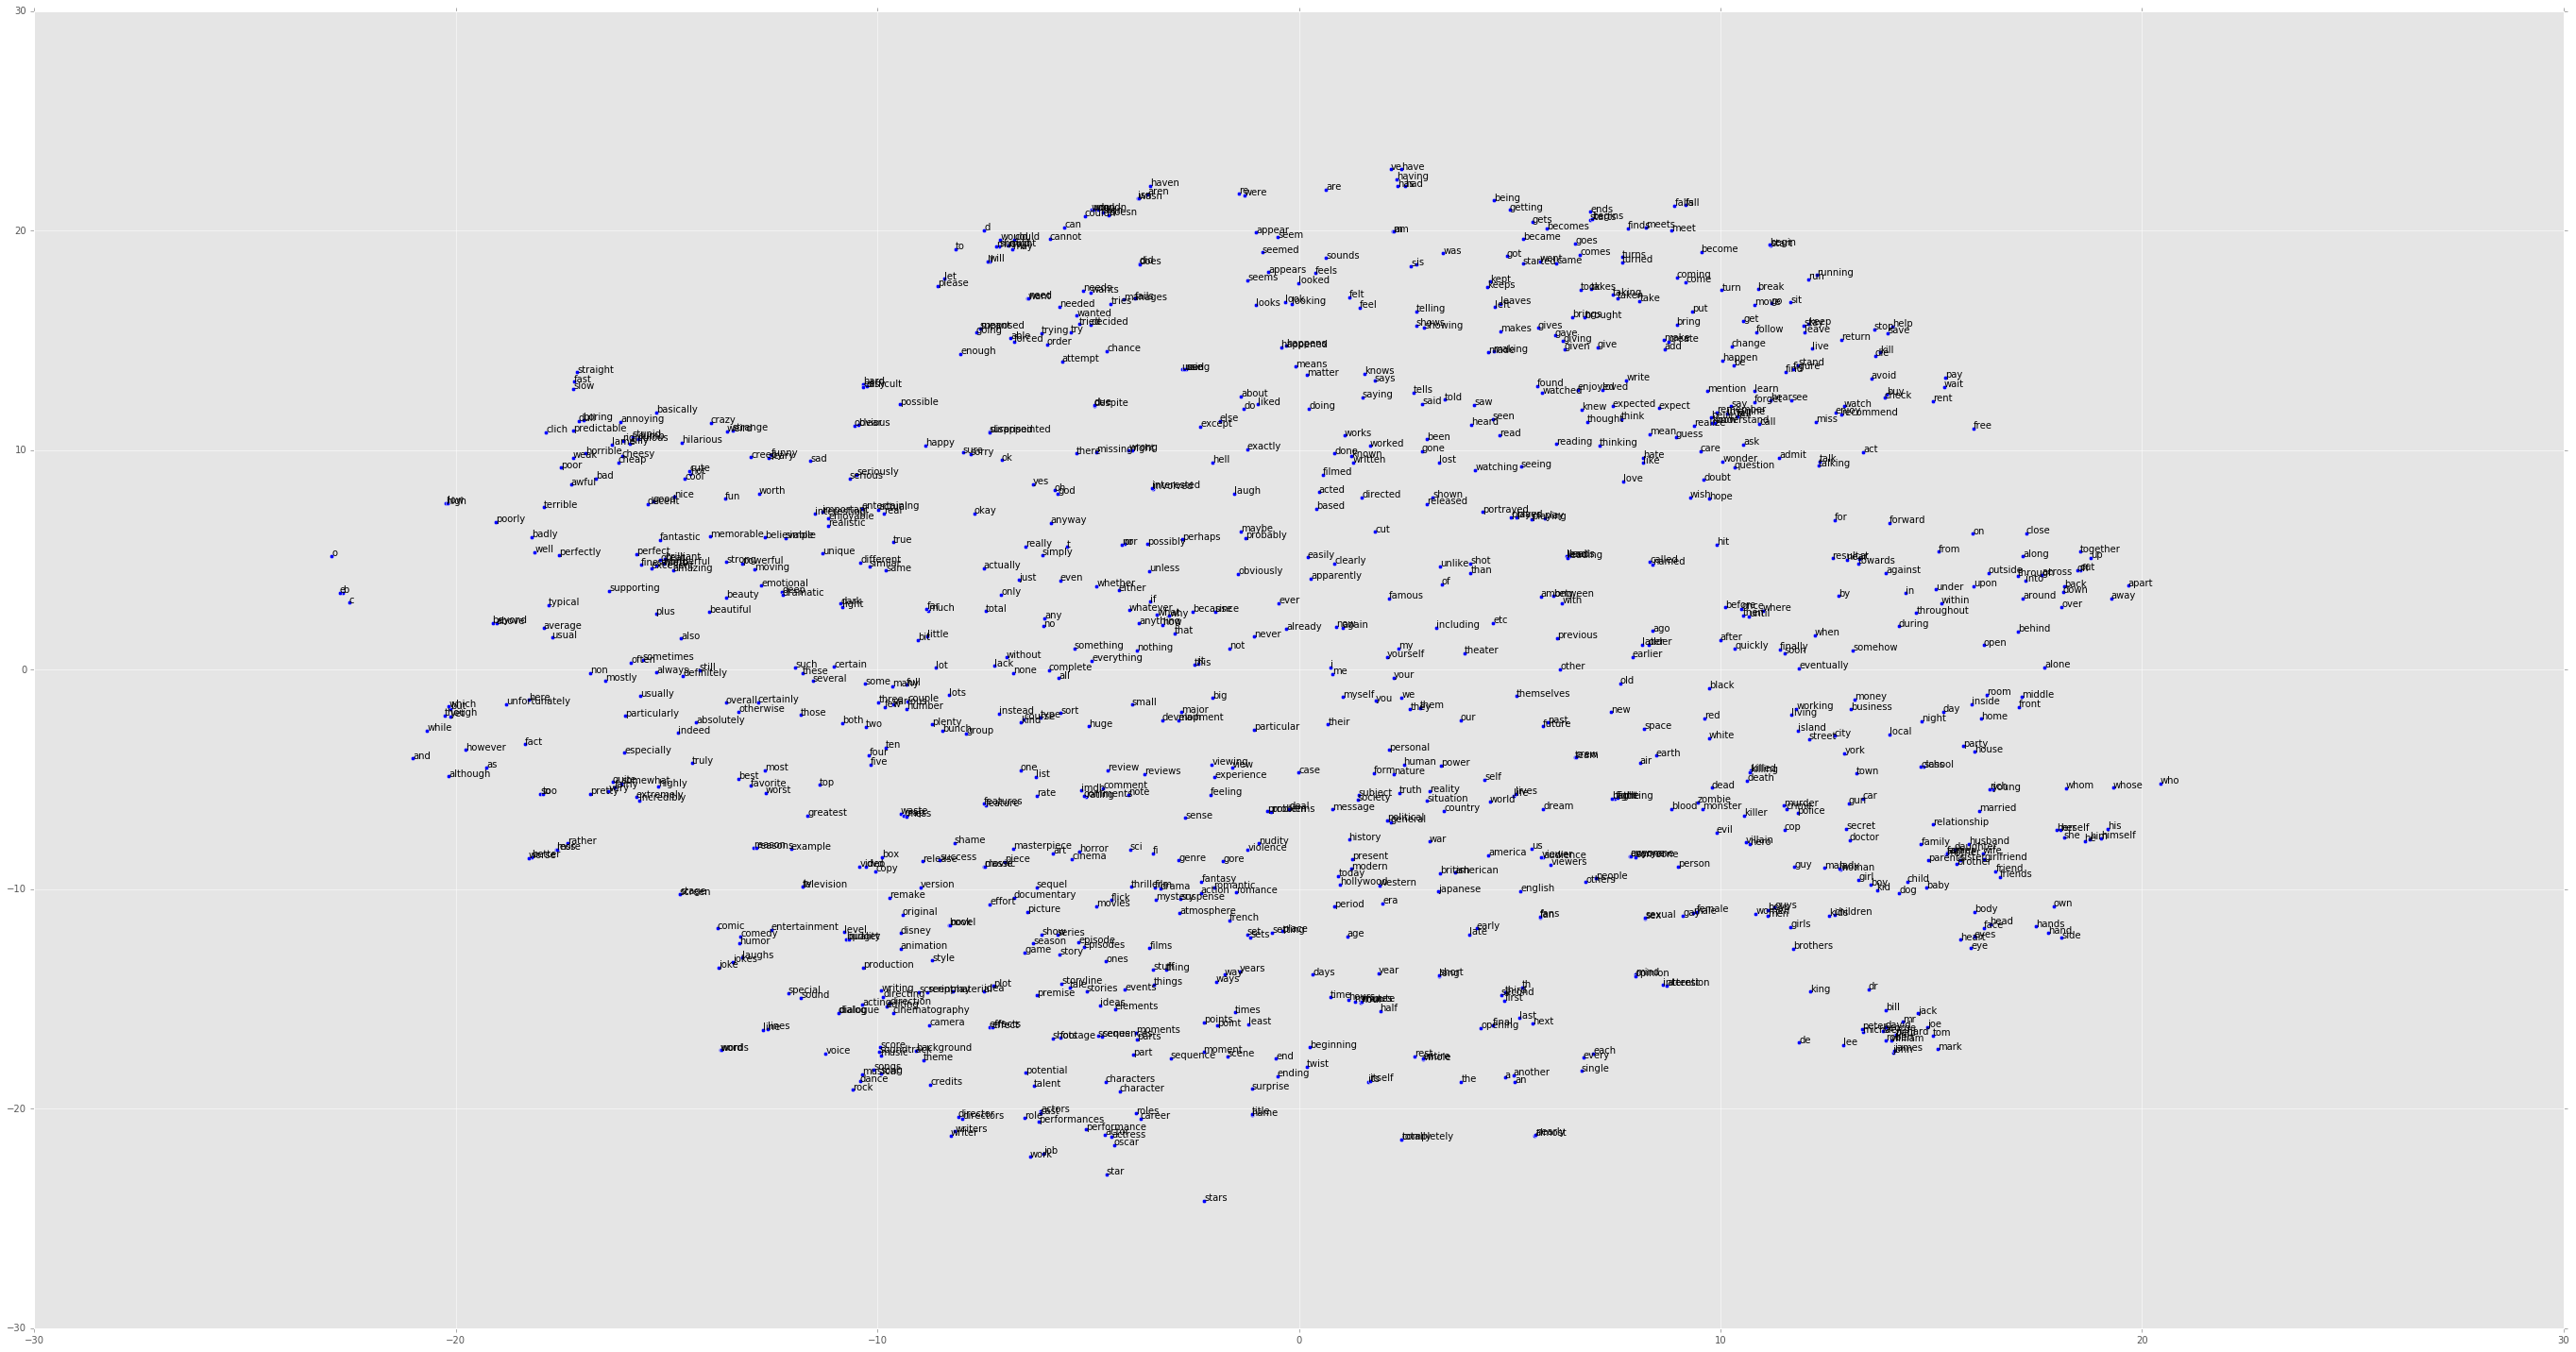

In [31]:
plt.figure(figsize=(48, 25))
plt.scatter(Y[:, 0], Y[:, 1])

for label, x, y in zip(vocabulary, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')